Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

Оцените ошибку модели из п.2 .

Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [21]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [29]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


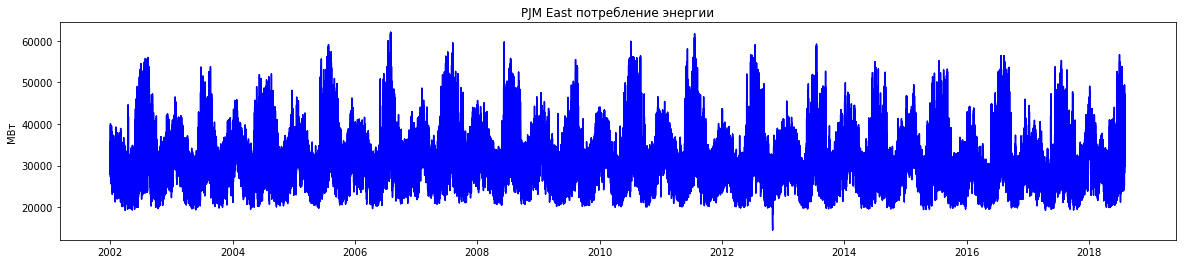

In [22]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [30]:
d_data=data.resample('D').mean()
d_data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


In [24]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [25]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)

In [31]:
df = pd.DataFrame(data_exp_1, index=d_data.index)
df.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


In [32]:
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)

df.head()

,0,t,t1,t2
Date,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257


In [42]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [43]:
train, test = split_data( df, '2017-09-09')

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
def h_boost(h,train=train, test=test):
    X_train = train.iloc[:-h,:]
    y_train = train[df.columns[0]].values[h:]
    X_test = test.iloc[:-h,:]
    y_test = test[df.columns[0]].values[h:]
    
    model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
    model_gb.fit( X_train, y_train ) 
    X_test_pred_gb = model_gb.predict(X_test)
    
    
    plt.figure( figsize=( 22, 4 ))

    plt.xlabel('Время')
    plt.ylabel('МВт')
    plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data' )
    plt.plot(test.index[h:],y_test, label='test data')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)
    print(f'Для глубины прогноза {h}')
    print(f'ошибка градиентного бустинга : {er_g:.3f} %')

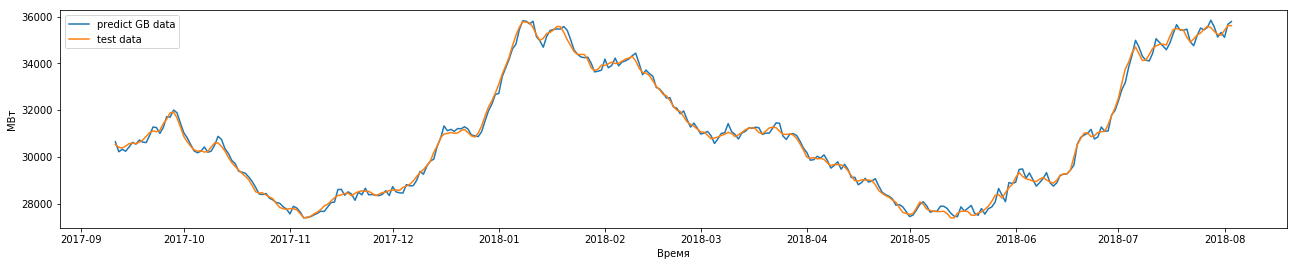

Для глубины прогноза 1
ошибка градиентного бустинга : 0.422 %


In [46]:
h_boost(1)

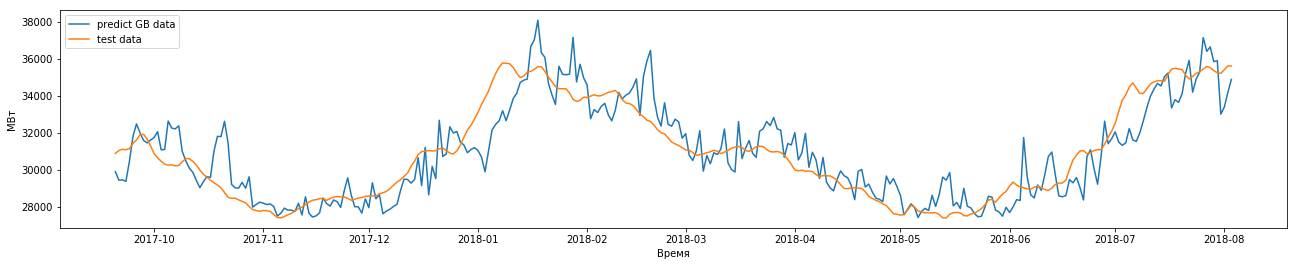

Для глубины прогноза 10
ошибка градиентного бустинга : 3.068 %


In [47]:
h_boost(10)

Чем больше h тем больше ошибка

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :). Стационарный, возможно с трендом, с циклом и сезоном

б) Количество денег, которые тратят покупатели в интернет магазине. Не стационарный, возможно с трендом, без цикла и возможно сезон

в) Вес растущего котенка.Не стационарный, с трендом, без цикла и сезона

г) Прирост объема деревьев в лесу от времени Стационарный, с трендом, возможно с циклом, с сезоном